<a href="https://colab.research.google.com/github/solobala/DLL30/blob/main/Dll30_DZ7_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание по теме «Рекуррентные сети-2»

# Задание 1.

Cгенерировать последовательности, которые бы состояли из символов цифр от 0 до 9 и формировались следующим образом: X - последовательность цифр, каждая из которых выбирается случайным образом из диапазона от 0 до 9,  y(0)=x(0), y(i) =x(0) + x(i). Если y(i) >=10, y(i) = y(i)-10
Научить модель предсказывать y(i) по x(i). Попробовать RNN, LSTM, GRU и последовательности длиной  [25, 75, 150]


## Импорт библиотек

In [2]:
import torch as tr
import copy
import math
import time

import torch
from torch import nn
import re
import random
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

In [3]:
import os
import sys
from google.colab import drive

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
%matplotlib inline

In [5]:
dev = tr.device('cuda' if tr.cuda.is_available() else 'cpu')
if dev.type == 'cuda': print('work on', tr.cuda.get_device_name(0))
else: print('work on CPU')

work on CPU


In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Вспомогательные функции

In [7]:
def f(x):
  """генерация последовательности цифр y"""
  return (x + x[:,0:1]) % 10

In [8]:
def asMinutes(s):
    """Вспомогательная функция перевода секунд  в минуты"""
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    """ длительность итерации обучения"""
    # now = time()
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [9]:
def showPlot(points1, points2, n_iters, print_every, title):
    """Визуализация обучения"""
    fig = plt.figure(figsize=(4,2))
    ax = fig.add_subplot(1, 1, 1)
    xdata = [i for i in range(print_every, n_iters+print_every, print_every)]
    ax.plot(xdata, points1, color='tab:blue')
    ax.plot(xdata, points2, color='tab:orange')
    ax.set_title(title)
    plt.show()

##2. Базовая архитектура RNN

In [10]:
class rnn1(tr.nn.Module):
    def __init__(self, n_classes, embedding_size, hidden_size, num_layers, rnn_type):
        super().__init__()
        self.emb = tr.nn.Embedding(n_classes, embedding_size)
        self.rnn = rnn_type(embedding_size, hidden_size, num_layers, batch_first = True)
        self.lin = tr.nn.Linear(hidden_size, n_classes)
    def forward(self, input):
        r = self.emb(input)
        r = self.rnn(r)[0]
        r = self.lin(r).squeeze()
        return r

##3. Входящие настройки RNN

In [38]:
n_iters        = 5000
n_classes      = 10
embedding_size = 10
hidden_size    = 50
num_layers     = 1
batch_size     = 100
seq_len        = 100
loss_best      = 10**10
learn_rate     = 0.001
rnn_list      = [tr.nn.RNN, tr.nn.LSTM, tr.nn.GRU]
s_l_list = [25, 75, 150] # Это длины последовательностей
print_every   = 500

##4. Эксперименты - анализ влияния размерности входного тензора и типа RNN ячейки на качество моделей RNN (loss, accuracy, learning time)

In [13]:
x = tr.randint(n_classes, (batch_size, 25))
y = f(x)
print(x[0].shape,y[0].shape) # Пример исходных данных - x и y - батчи из 100 тензоров, каждый по 25 элементоа

torch.Size([25]) torch.Size([25])


MAX_LEN = 25 rnnClass = RNN
Пройдено эпох:


  0%|          | 0/5000 [00:00<?, ?it/s]

(100 2%) 2.3009 0.1221 2.3005 0.1217
(200 4%) 2.2908 0.1363 2.2898 0.1372
(300 6%) 2.2786 0.1350 2.2783 0.1367
(400 8%) 2.2602 0.1357 2.2597 0.1362
(500 10%) 2.2431 0.1371 2.2432 0.1352
(600 12%) 2.2303 0.1355 2.2300 0.1357
(700 14%) 2.2216 0.1358 2.2215 0.1354
(800 16%) 2.2158 0.1364 2.2157 0.1350
(900 18%) 2.2115 0.1370 2.2117 0.1367
(1000 20%) 2.2085 0.1368 2.2077 0.1367
(1100 22%) 2.2040 0.1382 2.2042 0.1381
(1200 24%) 2.1979 0.1424 2.1981 0.1430
(1300 26%) 2.0733 0.2020 2.0712 0.2033
(1400 28%) 1.8211 0.2655 1.8220 0.2618
(1500 30%) 1.4741 0.3563 1.4669 0.3595
(1600 32%) 1.2055 0.4342 1.2029 0.4332
(1700 34%) 1.0779 0.4424 1.0719 0.4450
(1800 36%) 1.0219 0.4556 1.0173 0.4561
(1900 38%) 0.8992 0.5090 0.8935 0.5096
(2000 40%) 0.7997 0.5208 0.7979 0.5207
(2100 42%) 0.7630 0.5227 0.7628 0.5217
(2200 44%) 0.7415 0.5192 0.7406 0.5220
(2300 46%) 0.7250 0.5204 0.7253 0.5206
(2400 48%) 0.7152 0.5205 0.7156 0.5192
(2500 50%) 0.7072 0.5204 0.7072 0.5209
(2600 52%) 0.7014 0.5207 0.7015 0.5207

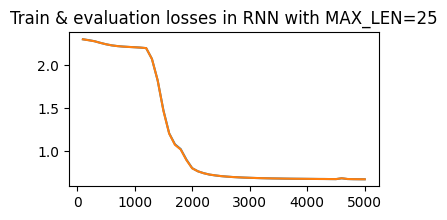

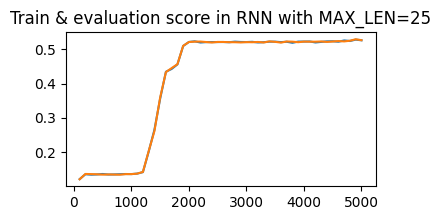

MAX_LEN = 25 rnnClass = LSTM
Пройдено эпох:


  0%|          | 0/5000 [00:00<?, ?it/s]

(100 2%) 2.3008 0.1168 2.3008 0.1158
(200 4%) 2.2949 0.1308 2.2952 0.1287
(300 6%) 2.2809 0.1330 2.2810 0.1322
(400 8%) 2.1250 0.2108 2.1200 0.2151
(500 10%) 1.4841 0.4089 1.4725 0.4192
(600 12%) 1.0236 0.6217 1.0161 0.6290
(700 14%) 0.6026 0.8189 0.6028 0.8170
(800 16%) 0.3338 0.9531 0.3323 0.9541
(900 18%) 0.1621 0.9991 0.1608 0.9993
(1000 20%) 0.0937 0.9996 0.0932 0.9997
(1100 22%) 0.0616 0.9999 0.0616 0.9999
(1200 24%) 0.0439 1.0000 0.0436 1.0000
(1300 26%) 0.0328 1.0000 0.0328 1.0000
(1400 28%) 0.0258 0.9999 0.0255 1.0000
(1500 30%) 0.0206 1.0000 0.0206 1.0000
(1600 32%) 0.0167 1.0000 0.0169 0.9999
(1700 34%) 0.0168 0.9997 0.0161 0.9998
(1800 36%) 0.0137 0.9999 0.0132 1.0000
(1900 38%) 0.0110 1.0000 0.0110 1.0000
(2000 40%) 0.0095 1.0000 0.0095 1.0000
(2100 42%) 0.0083 1.0000 0.0083 1.0000
(2200 44%) 0.0073 1.0000 0.0073 1.0000
(2300 46%) 0.0065 1.0000 0.0065 1.0000
(2400 48%) 0.0058 1.0000 0.0058 1.0000
(2500 50%) 0.0053 1.0000 0.0053 1.0000
(2600 52%) 0.0047 1.0000 0.0048 1.0000

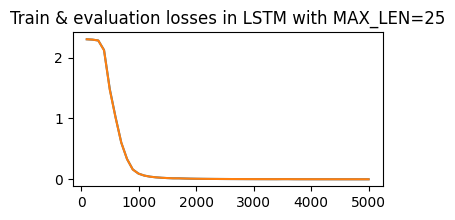

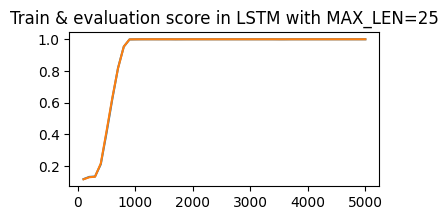

MAX_LEN = 25 rnnClass = GRU
Пройдено эпох:


  0%|          | 0/5000 [00:00<?, ?it/s]

(100 2%) 2.3003 0.1237 2.2997 0.1236
(200 4%) 2.2930 0.1353 2.2934 0.1356
(300 6%) 2.2793 0.1398 2.2789 0.1396
(400 8%) 2.1511 0.1951 2.1475 0.1939
(500 10%) 1.6247 0.2807 1.6224 0.2799
(600 12%) 1.3739 0.4177 1.3704 0.4174
(700 14%) 0.8932 0.7974 0.8876 0.8032
(800 16%) 0.4086 0.9919 0.4033 0.9928
(900 18%) 0.1914 0.9994 0.1909 0.9994
(1000 20%) 0.1121 1.0000 0.1116 1.0000
(1100 22%) 0.0750 1.0000 0.0746 1.0000
(1200 24%) 0.0550 1.0000 0.0548 1.0000
(1300 26%) 0.0428 1.0000 0.0425 1.0000
(1400 28%) 0.0344 1.0000 0.0342 1.0000
(1500 30%) 0.0282 1.0000 0.0282 1.0000
(1600 32%) 0.0236 1.0000 0.0237 1.0000
(1700 34%) 0.0202 1.0000 0.0201 1.0000
(1800 36%) 0.0189 0.9999 0.0183 1.0000
(1900 38%) 0.0160 1.0000 0.0159 1.0000
(2000 40%) 0.0138 1.0000 0.0139 1.0000
(2100 42%) 0.0122 1.0000 0.0122 1.0000
(2200 44%) 0.0109 1.0000 0.0109 1.0000
(2300 46%) 0.0098 1.0000 0.0098 1.0000
(2400 48%) 0.0088 1.0000 0.0088 1.0000
(2500 50%) 0.0080 1.0000 0.0079 1.0000
(2600 52%) 0.0072 1.0000 0.0072 1.0000

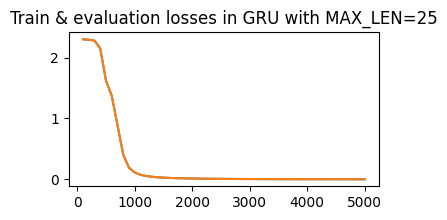

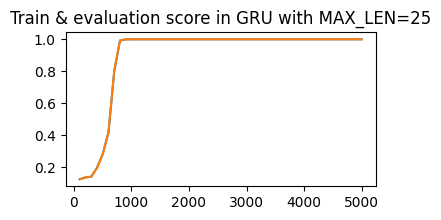

MAX_LEN = 75 rnnClass = RNN
Пройдено эпох:


  0%|          | 0/5000 [00:00<?, ?it/s]

(100 2%) 2.3045 0.1018 2.3043 0.1031
(200 4%) 2.3018 0.1068 2.3018 0.1053
(300 6%) 2.3003 0.1077 2.2999 0.1073
(400 8%) 2.2985 0.1079 2.2986 0.1080
(500 10%) 2.2967 0.1096 2.2968 0.1101
(600 12%) 2.2951 0.1100 2.2955 0.1089
(700 14%) 2.2933 0.1119 2.2939 0.1098
(800 16%) 2.2922 0.1104 2.2918 0.1114
(900 18%) 2.2899 0.1114 2.2901 0.1117
(1000 20%) 2.2877 0.1112 2.2878 0.1107
(1100 22%) 2.2852 0.1120 2.2852 0.1124
(1200 24%) 2.2830 0.1121 2.2830 0.1125
(1300 26%) 2.2805 0.1116 2.2807 0.1122
(1400 28%) 2.2784 0.1121 2.2787 0.1111
(1500 30%) 2.2768 0.1129 2.2771 0.1120
(1600 32%) 2.2757 0.1099 2.2755 0.1121
(1700 34%) 2.2745 0.1112 2.2743 0.1125
(1800 36%) 2.2733 0.1116 2.2733 0.1122
(1900 38%) 2.2722 0.1128 2.2721 0.1128
(2000 40%) 2.2712 0.1126 2.2713 0.1143
(2100 42%) 2.2699 0.1124 2.2697 0.1125
(2200 44%) 2.0987 0.1776 2.0930 0.1772
(2300 46%) 1.7785 0.2138 1.7785 0.2112
(2400 48%) 1.6842 0.2133 1.6828 0.2136
(2500 50%) 1.6475 0.2207 1.6441 0.2191
(2600 52%) 1.6929 0.2142 1.6872 0.2149

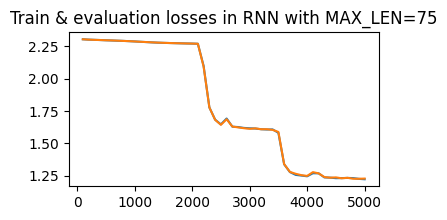

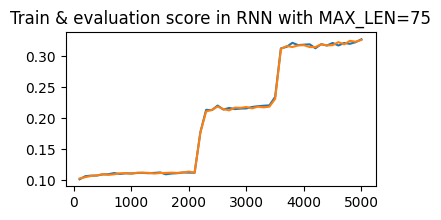

MAX_LEN = 75 rnnClass = LSTM
Пройдено эпох:


  0%|          | 0/5000 [00:00<?, ?it/s]

(100 2%) 2.3029 0.1019 2.3031 0.1012
(200 4%) 2.3020 0.1084 2.3021 0.1083
(300 6%) 2.3016 0.1083 2.3016 0.1089
(400 8%) 2.3005 0.1104 2.3008 0.1096
(500 10%) 2.2988 0.1100 2.2985 0.1120
(600 12%) 2.2953 0.1121 2.2954 0.1110
(700 14%) 2.2898 0.1143 2.2891 0.1157
(800 16%) 2.0048 0.2056 2.0047 0.2038
(900 18%) 1.7653 0.2162 1.7669 0.2129
(1000 20%) 1.5580 0.3005 1.5553 0.3011
(1100 22%) 1.3523 0.3367 1.3517 0.3340
(1200 24%) 1.2229 0.4092 1.2191 0.4136
(1300 26%) 1.0370 0.5329 1.0315 0.5359
(1400 28%) 0.9135 0.5926 0.9101 0.5970
(1500 30%) 0.7320 0.7070 0.7266 0.7098
(1600 32%) 0.5629 0.7785 0.5606 0.7800
(1700 34%) 0.4318 0.8381 0.4314 0.8390
(1800 36%) 0.2786 0.9029 0.2769 0.9048
(1900 38%) 0.2271 0.9057 0.2224 0.9087
(2000 40%) 0.1943 0.9279 0.1928 0.9276
(2100 42%) 0.0911 0.9958 0.0903 0.9962
(2200 44%) 0.0571 0.9991 0.0562 0.9992
(2300 46%) 0.0437 0.9995 0.0432 0.9996
(2400 48%) 0.0348 0.9996 0.0353 0.9996
(2500 50%) 0.0289 0.9998 0.0287 0.9998
(2600 52%) 0.0244 0.9998 0.0250 0.9996

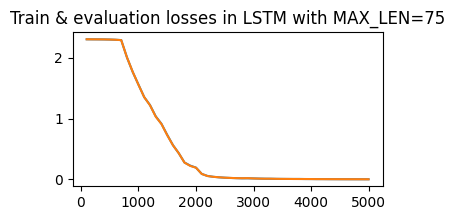

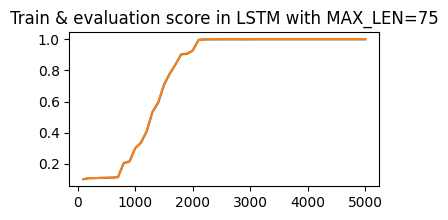

MAX_LEN = 75 rnnClass = GRU
Пройдено эпох:


  0%|          | 0/5000 [00:00<?, ?it/s]

(100 2%) 2.3034 0.1008 2.3030 0.1017
(200 4%) 2.3019 0.1082 2.3020 0.1064
(300 6%) 2.3014 0.1124 2.3012 0.1115
(400 8%) 2.3010 0.1113 2.3007 0.1118
(500 10%) 2.2999 0.1117 2.2999 0.1124
(600 12%) 2.2985 0.1126 2.2991 0.1120
(700 14%) 2.2963 0.1136 2.2964 0.1144
(800 16%) 2.2587 0.1482 2.2583 0.1470
(900 18%) 1.8048 0.2302 1.8014 0.2323
(1000 20%) 1.2570 0.4316 1.2490 0.4353
(1100 22%) 0.8191 0.5064 0.8181 0.5068
(1200 24%) 0.7364 0.5081 0.7360 0.5092
(1300 26%) 0.7139 0.5137 0.7139 0.5131
(1400 28%) 0.6968 0.5488 0.6967 0.5476
(1500 30%) 0.6635 0.6087 0.6638 0.6065
(1600 32%) 0.6024 0.7075 0.6039 0.7048
(1700 34%) 0.4840 0.8675 0.4845 0.8682
(1800 36%) 0.3154 0.9685 0.3145 0.9688
(1900 38%) 0.1846 0.9956 0.1833 0.9957
(2000 40%) 0.1145 0.9982 0.1130 0.9982
(2100 42%) 0.0770 0.9994 0.0762 0.9995
(2200 44%) 0.0562 0.9997 0.0559 0.9997
(2300 46%) 0.0426 0.9999 0.0427 1.0000
(2400 48%) 0.0339 1.0000 0.0337 1.0000
(2500 50%) 0.0275 1.0000 0.0276 1.0000
(2600 52%) 0.0231 1.0000 0.0230 1.0000

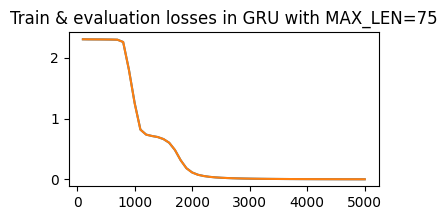

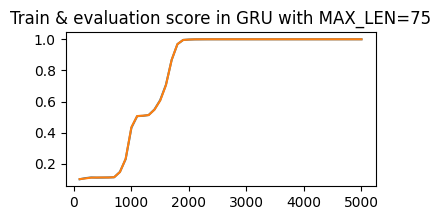

MAX_LEN = 150 rnnClass = RNN
Пройдено эпох:


  0%|          | 0/5000 [00:00<?, ?it/s]

(100 2%) 2.3052 0.1018 2.3048 0.1036
(200 4%) 2.3029 0.1015 2.3023 0.1039
(300 6%) 2.3021 0.1038 2.3017 0.1046
(400 8%) 2.3017 0.1034 2.3017 0.1037
(500 10%) 2.3013 0.1029 2.3013 0.1033
(600 12%) 2.3007 0.1036 2.3006 0.1038
(700 14%) 2.2996 0.1063 2.2997 0.1049
(800 16%) 2.2990 0.1061 2.2990 0.1049
(900 18%) 2.2981 0.1050 2.2982 0.1055
(1000 20%) 2.2972 0.1063 2.2975 0.1046
(1100 22%) 2.2965 0.1061 2.2964 0.1051
(1200 24%) 2.2953 0.1070 2.2955 0.1044
(1300 26%) 2.2946 0.1053 2.2945 0.1047
(1400 28%) 2.2936 0.1065 2.2936 0.1057
(1500 30%) 2.2925 0.1050 2.2925 0.1061
(1600 32%) 2.2917 0.1054 2.2916 0.1074
(1700 34%) 2.2909 0.1059 2.2908 0.1077
(1800 36%) 2.2900 0.1065 2.2903 0.1059
(1900 38%) 2.2895 0.1068 2.2895 0.1056
(2000 40%) 2.2891 0.1057 2.2890 0.1070
(2100 42%) 2.2887 0.1063 2.2887 0.1058
(2200 44%) 2.2883 0.1059 2.2883 0.1055
(2300 46%) 2.2880 0.1058 2.2880 0.1052
(2400 48%) 2.2877 0.1059 2.2877 0.1068
(2500 50%) 2.2873 0.1056 2.2873 0.1053
(2600 52%) 2.2871 0.1063 2.2871 0.1052

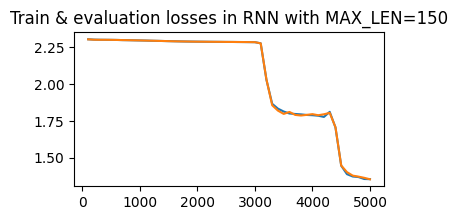

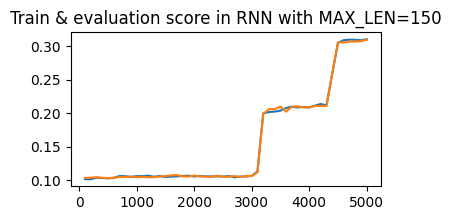

MAX_LEN = 150 rnnClass = LSTM
Пройдено эпох:


  0%|          | 0/5000 [00:00<?, ?it/s]

(100 2%) 2.3032 0.1007 2.3033 0.1014
(200 4%) 2.3028 0.0995 2.3027 0.1013
(300 6%) 2.3027 0.1004 2.3025 0.1030
(400 8%) 2.3023 0.1050 2.3024 0.1042
(500 10%) 2.3024 0.1043 2.3022 0.1046
(600 12%) 2.3021 0.1040 2.3020 0.1044
(700 14%) 2.3016 0.1062 2.3016 0.1059
(800 16%) 2.3013 0.1053 2.3012 0.1046
(900 18%) 2.3008 0.1038 2.3009 0.1035
(1000 20%) 2.2997 0.1060 2.2995 0.1079
(1100 22%) 2.2985 0.1058 2.2983 0.1066
(1200 24%) 2.2967 0.1075 2.2969 0.1040
(1300 26%) 2.2949 0.1059 2.2949 0.1058
(1400 28%) 2.2928 0.1067 2.2930 0.1059
(1500 30%) 2.2236 0.1458 2.2211 0.1446
(1600 32%) 1.7770 0.2025 1.7721 0.2042
(1700 34%) 1.6509 0.2052 1.6456 0.2080
(1800 36%) 1.6341 0.2065 1.6391 0.2078
(1900 38%) 1.4790 0.2724 1.4720 0.2746
(2000 40%) 1.1656 0.3823 1.1651 0.3858
(2100 42%) 0.9808 0.4343 0.9833 0.4359
(2200 44%) 0.7504 0.5016 0.7487 0.5033
(2300 46%) 0.7150 0.5028 0.7149 0.5023
(2400 48%) 0.7059 0.5050 0.7058 0.5050
(2500 50%) 0.7013 0.5055 0.7014 0.5029
(2600 52%) 0.6986 0.5037 0.6989 0.5017

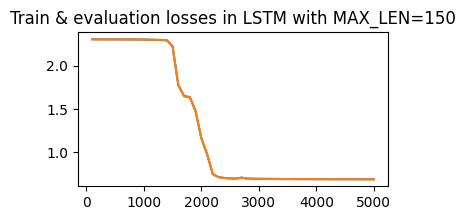

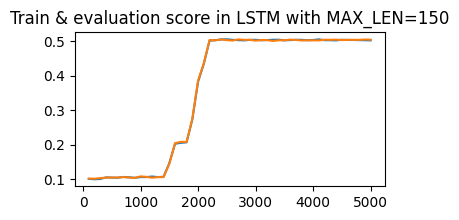

MAX_LEN = 150 rnnClass = GRU
Пройдено эпох:


  0%|          | 0/5000 [00:00<?, ?it/s]

(100 2%) 2.3030 0.1025 2.3035 0.1011
(200 4%) 2.3026 0.1020 2.3026 0.1030
(300 6%) 2.3023 0.1026 2.3023 0.1043
(400 8%) 2.3022 0.1039 2.3025 0.1031
(500 10%) 2.3019 0.1048 2.3018 0.1051
(600 12%) 2.3017 0.1050 2.3019 0.1031
(700 14%) 2.3014 0.1054 2.3014 0.1056
(800 16%) 2.3009 0.1068 2.3010 0.1058
(900 18%) 2.3004 0.1063 2.3002 0.1083
(1000 20%) 2.2993 0.1075 2.2995 0.1072
(1100 22%) 2.2969 0.1142 2.2968 0.1149
(1200 24%) 1.8895 0.2070 1.8849 0.2078
(1300 26%) 1.2136 0.4288 1.2072 0.4313
(1400 28%) 0.8001 0.5015 0.7992 0.5011
(1500 30%) 0.7328 0.5042 0.7327 0.5050
(1600 32%) 0.7143 0.5050 0.7140 0.5065
(1700 34%) 0.7053 0.5145 0.7050 0.5163
(1800 36%) 0.6909 0.5595 0.6907 0.5632
(1900 38%) 0.6509 0.6160 0.6489 0.6208
(2000 40%) 0.5793 0.7112 0.5771 0.7147
(2100 42%) 0.4588 0.8195 0.4550 0.8227
(2200 44%) 0.2906 0.9519 0.2897 0.9527
(2300 46%) 0.1632 0.9886 0.1609 0.9887
(2400 48%) 0.1005 0.9943 0.1010 0.9942
(2500 50%) 0.0664 0.9977 0.0655 0.9978
(2600 52%) 0.0471 0.9988 0.0468 0.9987

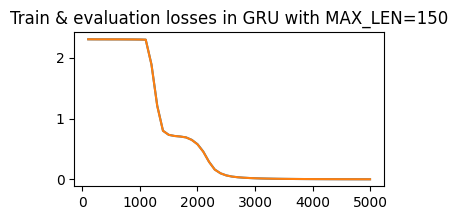

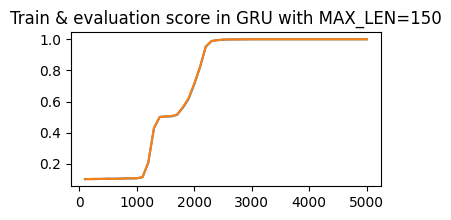

In [16]:
df = pd.DataFrame(columns = ['rnnClass', 'max_len','time', 'train_loss', 'train_acc', 'val_loss', 'val_acc'])

for i in s_l_list:
    for rnn_type in rnn_list:
        print('======================================')
        print(f'MAX_LEN = {i} rnnClass = {rnn_type.__name__}')
        print('======================================')
        model = rnn1(n_classes, embedding_size, hidden_size, num_layers, rnn_type).to(dev)
        opt   = tr.optim.Adam(model.parameters(), lr=learn_rate)
        crit  = tr.nn.CrossEntropyLoss()
        t_a, t_l, v_a, v_l = [], [], [], []
        print('Пройдено эпох:')
        start = time.time()
        for iter in tqdm(range(1,(n_iters+1))):
            print_train_loss = 0
            print_val_loss = 0
            print_train_acc = 0
            print_val_acc = 0

            # train loop
            model.train()
            x = tr.randint(n_classes, (batch_size, i)).to(dev)
            y = f(x)
            opt.zero_grad()
            pred = model(x) # torch.Size([100, 25, 10])
            train_acc = (y == pred.argmax(dim=-1)).sum() / tr.tensor(y.shape).prod()
            train_loss = crit(pred.reshape(-1, n_classes), y.flatten()).to(dev)  #
            train_loss.backward()
            opt.step()

            # evaluation loop
            model.eval()
            x = tr.randint(n_classes, (batch_size, i)).to(dev)
            y = f(x)
            pred = model(x)
            val_loss = crit(pred.reshape(-1, n_classes), y.flatten())
            val_acc = (y == pred.argmax(dim=-1)).sum() / tr.tensor(y.shape).prod()


            print_train_loss += train_loss
            print_val_loss += val_loss
            print_train_acc += train_acc
            print_val_acc += val_acc

            if iter % print_every == 0:

                train_loss_avg = print_train_loss / print_every
                t_l.append(train_loss_avg.detach().numpy())

                val_loss_avg = print_val_loss / print_every
                v_l.append(val_loss_avg.detach().numpy())

                train_acc_avg = print_train_acc / print_every
                t_a.append(train_acc_avg.detach().numpy())

                val_acc_avg = print_val_acc / print_every
                v_a.append(val_acc_avg.detach().numpy())

                print('(%d %d%%) %.4f %.4f %.4f %.4f' % (iter, iter / n_iters * 100, train_loss_avg, train_acc_avg, val_loss_avg, val_acc_avg))

        print('Learning_time:', time.time() - start)
        showPlot(t_l, v_l, n_iters,f'Train & evaluation losses in {rnn_type.__name__} with MAX_LEN={i}')
        print()
        showPlot(t_a, v_a, n_iters, f'Train & evaluation score in {rnn_type.__name__} with MAX_LEN={i}')
        df.loc[len(df) + 1] = [rnn_type.__name__, i, time.time() - start, t_l[-1], t_a[-1], v_l[-1], v_a[-1]]
        # df_2.loc[rnn_type.__name__, i] = round(val_acc.item(),5)

##5. Выводы

###5.1. Функция потерь

In [39]:
pd.pivot_table(df[['rnnClass', 'max_len','val_loss']],
               index=['rnnClass'],
               values=["val_loss"],
               columns=["max_len"]).style.format('{:.4f}', na_rep='-').background_gradient(cmap='Blues')

При обучении в течение 5000 эпох наименьшие потери наблюдаются в случае использования LSTM ячейки при минимальной длине последовательности.

Во всех остальных экспериментах наилучшие результаты  в части потерь достигаютсм при использовании в архитектуре модели GRU ячейки. При этом с ростом длины последовательности закономерно происходит и рост потерь.

### 5.2. Accuracy

In [35]:
pd.pivot_table(df[['rnnClass', 'max_len','val_acc']] ,
               index=["rnnClass"],
               values=["val_acc"],
               columns=["max_len"]).style.format('{:.4f}', na_rep='-').background_gradient(cmap='Blues')

При выбранном числе эпох благодаря GRU ячейкам при всех длинах последовательностей удалось достигнуть максимальной точности модели.

RNN ячейки показали невысокую точность - около 50%.

Промежуточное положение заняли модели с LSTM-ячейками. При длине последовательности 150 и выбранном количестве эпох обучения удовлетвориельной точности достигнуть не удалось

###5.3. Время обучения

In [37]:
pd.pivot_table(df[['rnnClass', 'max_len','time']] ,
               index=["rnnClass"],
               values=["time"],
               columns=["max_len"]).style.format('{:.4f}', na_rep='-').background_gradient(cmap='Blues')

Как можно заметить из таблицы, минимальное время обучения - при использовании RNN ячеек, максимальное - при использовании GRU.

Следует заметить, однако, что точность как при использовании RNN, при использовании других типов ячеек достигается значительно раньше - не за 5000, а всего за 550 эпох в случае LSTM (примерно за 14 с) и за 650 - в случае GRU (примерно за 20 с) для длины последовательности 25. Для длины последовательности 150 цифр сопоставимая с RNN точность при использовании LSTM достигается немного быстрее, а при использовании GRU - еще быстрее

Лучшие результаты показала модель на основе GRU, худшие - модель на основе RNN. При этом, чем короче входной тензор, тем лучше результат модели.

Если важна скорость обучения и доступные вычислительные ресурсы ограничены, GRU может быть предпочтительнее из-за своей более простой структуры и меньшего количества параметров по сравнению с LSTM.

Для более простых или меньших наборов данных GRU может быть достаточно, поскольку она может достаточно эффективно обучаться на таких данных, не теряя в производительности.

Если задача требует более детального управления информацией и долгосрочной памяти (например, в сложных задачах обработки естественного языка с длинными зависимостями), LSTM может быть более подходящим выбором благодаря своей дополнительной сложности и дополнительному контролю над информацией.

для датасета, используемого в данной задаче, наилучшие результаты были получены при использовании GRU. Функциональность lSTM здесь не требуется.

#Задание 2

Применить LSTM для генерации текста / Фридрих Ницше


## 2.1. Загрузка датасета

In [ ]:
!wget https://s3.amazonaws.com/text-datasets/nietzsche.txt

--2024-01-05 20:19:38--  https://s3.amazonaws.com/text-datasets/nietzsche.txt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.174.184, 52.216.40.184, 52.217.102.54, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.174.184|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 600901 (587K) [text/plain]
Saving to: ‘nietzsche.txt’

nietzsche.txt       100%[===================>] 586.82K  1.85MB/s    in 0.3s    

2024-01-05 20:19:39 (1.85 MB/s) - ‘nietzsche.txt’ saved [600901/600901]



In [ ]:
with open('nietzsche.txt', encoding='utf-8') as f:
    text = f.read().lower()
print('length:', len(text))

length: 600893


## 2.2. Обработка данных

In [ ]:
INDEX_TO_CHAR = sorted(list(set(text)))
CHAR_TO_INDEX = {c: i for i, c in enumerate(INDEX_TO_CHAR)}
MAX_LEN       = 40
STEP          = 3
SENTENCES     = []
NEXT_CHARS    = []

text = re.sub('[^a-z ]', ' ', text)
text = re.sub('\s+', ' ', text)

for i in range(0, len(text) - MAX_LEN, STEP):
    SENTENCES.append(text[i: i + MAX_LEN])
    NEXT_CHARS.append(text[i + MAX_LEN])
print('Num sents:', len(SENTENCES))

Num sents: 193075


In [ ]:
X = torch.zeros((len(SENTENCES), MAX_LEN), dtype=int)
Y = torch.zeros((len(SENTENCES)), dtype=int)

for i, sentence in enumerate(SENTENCES):
    for t, char in enumerate(sentence):
        X[i, t] = CHAR_TO_INDEX[char]
    Y[i] = CHAR_TO_INDEX[NEXT_CHARS[i]]

BATCH_SIZE = 256
dataset    = torch.utils.data.TensorDataset(X, Y)
data       = torch.utils.data.DataLoader(dataset, BATCH_SIZE, shuffle=True)

## 2.3. Базовая архитектура сети

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, rnnClass, dictionary_size, embedding_size, num_hiddens, num_classes):
        super().__init__()

        self.num_hiddens = num_hiddens
        self.embedding   = nn.Embedding(dictionary_size, embedding_size)
        self.hidden      = rnnClass(embedding_size, num_hiddens, batch_first=True)
        self.output      = nn.Linear(num_hiddens, num_classes)

    def forward(self, X):
        out         = self.embedding(X)
        _, state    = self.hidden(out)
        predictions = self.output(state[0])
        return predictions.squeeze(0)

## 2.4. Вспомогательные функции для генерации текста

In [ ]:
def sample(preds):
    softmaxed = torch.softmax(preds, 0)
    probas    = torch.distributions.multinomial.Multinomial(1, softmaxed).sample()
    return probas.argmax()

def generate_text():
    start_index = random.randint(0, len(text) - MAX_LEN - 1)

    generated = ''
    sentence  = text[start_index: start_index + MAX_LEN]
    generated += sentence

    for i in range(MAX_LEN):
        x_pred = torch.zeros((1, MAX_LEN), dtype=int)
        for t, char in enumerate(generated[-MAX_LEN:]):
            x_pred[0, t] = CHAR_TO_INDEX[char]

        preds     = model(x_pred)[0].cpu()
        next_char = INDEX_TO_CHAR[sample(preds)]
        generated = generated + next_char

    print(generated[:MAX_LEN] + '|' + generated[MAX_LEN:])

## 2.5. Обучение модели lstm

In [ ]:
model     = NeuralNetwork(nn.LSTM, len(CHAR_TO_INDEX), 64, 128, len(CHAR_TO_INDEX)).to(dev)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.003)

for ep in range(100):
    start        = time.time()
    train_loss   = 0.
    train_passed = 0

    model.train()
    for X_b, y_b in tqdm.tqdm_notebook(data):
        X_b, y_b    = X_b.to(dev), y_b.to(dev)
        optimizer.zero_grad()
        answers     = model.forward(X_b)
        loss        = criterion(answers, y_b)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        train_passed += 1

    print("Epoch {}. Time: {:.3f}, Train loss: {:.3f}".format(ep, time.time() - start, train_loss / train_passed))
    model.eval()
    generate_text()

<ipython-input-35-ba96186887fe>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for X_b, y_b in tqdm.tqdm_notebook(data):


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 0. Time: 222.153, Train loss: 1.966
ould possibly be given us in the present|ir and vorally yo tials suthich abys hor


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 1. Time: 208.108, Train loss: 1.636
even the cogent reason are felt to be da|me even instained it food of eynowil sym


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 2. Time: 206.175, Train loss: 1.522
portant refinement of vision and of crit|ten it i heach eadived conccentive is pe


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 3. Time: 205.109, Train loss: 1.453
these little tokens of kindly feeling an|king that wishe onfulations are apons ar


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 4. Time: 204.651, Train loss: 1.408
oism is not bad because the idea of the |religiestakes a pryper atoming reskpow t


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 5. Time: 203.958, Train loss: 1.376
s what is that really a pessimist apart |and we more has of domicable of could wi


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 6. Time: 205.235, Train loss: 1.350
the tragic poets for there is ever less |so conceticionis so one we domstable rel


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 7. Time: 206.285, Train loss: 1.328
t english morality to be recognized as a|nd man appearously if itself does or typ


  0%|          | 0/755 [00:00<?, ?it/s]